In [1]:
# Import the necessary libraries
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

import shap
import lime
import lime.lime_tabular

In [2]:
rail = pd.read_csv('rail.csv', index_col=0)
rail.head()
# Standardize the data
scaler = StandardScaler()
rail_standardized = scaler.fit_transform(rail)
# Divide data into training and test data
X_train, X_test = train_test_split(rail_standardized, test_size=0.2, random_state=42)

# Create pipelines for each combination of PCA/t-SNE and KMeans
pipeline = Pipeline([
    ('pca', PCA()),
    ('kmeans', KMeans())
])
# Paramètres à rechercher pour chaque pipeline
param_grid = {
    'pca__n_components': range(2, 5),  # Nombre de composantes principales pour PCA de 2 à 10
    'kmeans__n_clusters': range(2, 11)   # Nombre de clusters pour KMeans de 2 à 20
}

# Définir une fonction de scoring pour la silhouette
def silhouette_scorer(estimator, X):
    clusters = estimator.fit_predict(X)
    score = silhouette_score(X, clusters)
    return score


In [3]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5,scoring=silhouette_scorer)

# Entraîner la grille de recherche
grid_search.fit(X_train)

# Obtenir les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres :", best_params)

C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default 

C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default 

Meilleurs paramètres : {'kmeans__n_clusters': 4, 'pca__n_components': 3}


C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


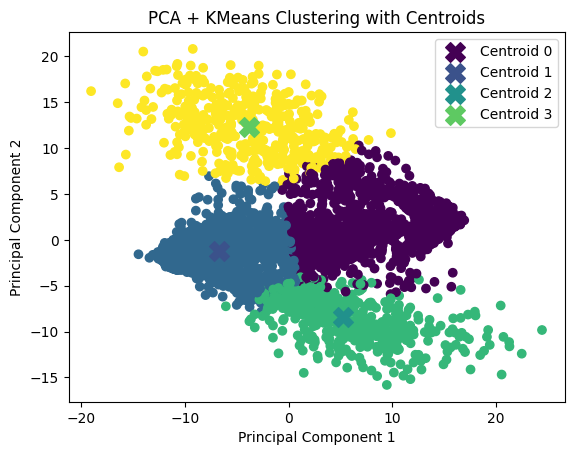

In [9]:
# Extracting the reduced PCA components
pca_components = grid_search.best_estimator_['pca'].transform(X_train)
clusters_pca = grid_search.best_estimator_.named_steps['kmeans'].labels_
centroids_pca = grid_search.best_estimator_.named_steps['kmeans'].cluster_centers_

# Bagging Classifier
#bagging_pipeline = BaggingClassifier(base_estimator=grid_search.best_estimator_, n_estimators=10)
#bagging_pipeline.fit(X_train)

# AdaBoost Classifier
#adaboost_pipeline = AdaBoostClassifier(base_estimator=grid_search.best_estimator_, n_estimators=50, learning_rate=1.0)
#adaboost_pipeline.fit(X_train)


# Plotting the scatter plot using the PCA components
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters_pca, cmap='viridis')
plt.title('PCA + KMeans Clustering with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plotting centroids with different colors and creating legend
for i, centroid in enumerate(centroids_pca):
    plt.scatter(centroid[0], centroid[1], marker='X', s=200, label=f'{i + 1} group centroid')

plt.legend()
plt.show()


Cluster 0:


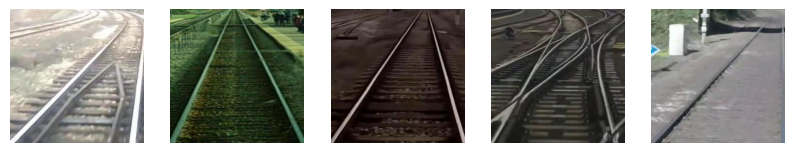

Cluster 1:


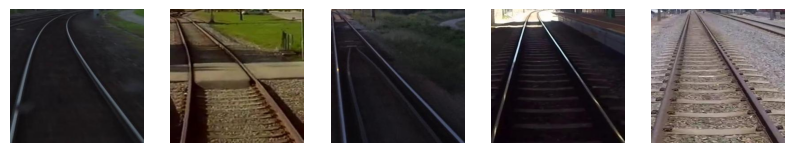

Cluster 2:


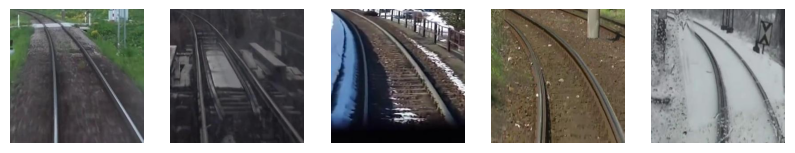

Cluster 3:


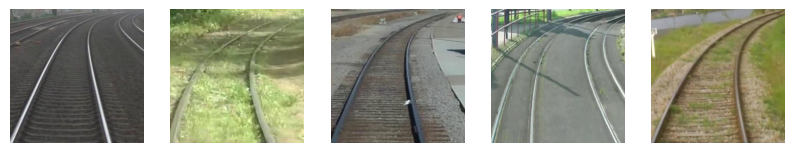

In [10]:
# Chemin vers le dossier contenant les images
image_folder = 'rs19_val_cropped_resized'

# Fonction pour charger une image à partir du nom de fichier
def load_image(file_name):
    image_path = os.path.join(image_folder, file_name)
    return Image.open(image_path)

# Obtenir les noms de fichiers correspondant aux index du DataFrame 'rail'
image_files = rail.index.astype(str) + '.jpg'

# Prédire les clusters pour l'ensemble des données
clusters = grid_search.predict(rail_standardized)
best_n_clusters = best_params['kmeans__n_clusters']
# Créer un dictionnaire pour stocker les chemins d'accès aux images pour chaque cluster
cluster_images = {cluster: [] for cluster in range(best_n_clusters)}

# Associer les clusters aux images
for i, file_name in enumerate(image_files):
    cluster_images[clusters[i]].append(file_name)

# Visualiser un échantillon d'images de chaque cluster
for cluster, images in cluster_images.items():
    print(f"Cluster {cluster}:")
    plt.figure(figsize=(10, 6))
    for i in range(min(len(images), 5)):  # Afficher jusqu'à 5 images de chaque cluster
        image = load_image(images[i])
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()


In [11]:
# Initialize LIME explainer in clustering mode and provide feature names and feature values
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode='classification', feature_names=rail.columns, discretize_continuous=False)

# Explain individual instances (instances similar to cluster centroids)
for centroid in centroids_pca:
    synthetic_instance = np.tile(centroid, (100, 1))  # Create synthetic instance around centroid
    synthetic_instance = synthetic_instance.reshape(1, -1)  # Reshape to match expected format
    exp = explainer.explain_instance(synthetic_instance[0], grid_search.predict, num_features=best_n_clusters)  
    exp.show_in_notebook(show_all=False)


ValueError: operands could not be broadcast together with shapes (5000,300) (200,) 